<h1>Smart Grid Stability Prediction </h1>

In [17]:

# importing library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, confusion_matrix, precision_score, recall_score, fbeta_score
from scipy import stats

<h2>Exploratory Data Analysis </h2>

In [18]:
# loading the dataset
# file_path = "/kaggle/input/smart-grid-stability/smart_grid_stability_augmented.csv"
file_path = "smart_grid_stability_augmented.csv"
df = pd.read_csv(file_path)

In [19]:
def load_and_examine(df):
    """
    Initial examination of the dataset
    """
    # Basic information
    print("Dataset Shape:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    
    # Basic statistics
    print("\nNumerical Summary Statistics:")
    print(df.describe())
    
    # For categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print("\nCategorical Columns Summary:")
        for col in categorical_cols:
            print(f"\n{col} value counts:")
            print(df[col].value_counts())

def analyze_distributions(df, numerical_cols):
    """
    Analyze distributions of numerical variables
    """
    for col in numerical_cols:
        plt.figure(figsize=(12, 4))
        
        # Histogram
        plt.subplot(1, 3, 1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        
        # Box Plot
        plt.subplot(1, 3, 2)
        sns.boxplot(y=df[col])
        plt.title(f'Box Plot of {col}')
        
        # Q-Q Plot
        plt.subplot(1, 3, 3)
        stats.probplot(df[col].dropna(), dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of {col}')
        
        plt.tight_layout()
        plt.show()
        
        # Skewness and Kurtosis
        print(f"\nSkewness of {col}: {df[col].skew():.2f}")
        print(f"Kurtosis of {col}: {df[col].kurtosis():.2f}")

def correlation_analysis(df, numerical_cols):
    """
    Analyze correlations between numerical variables
    """
    # Correlation matrix
    corr_matrix = df[numerical_cols].corr()
    
    # Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.show()
    
    # Find high correlations
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                                corr_matrix.iloc[i, j]))
    
    if high_corr:
        print("\nHigh Correlations (>0.7):")
        for var1, var2, corr in high_corr:
            print(f"{var1} - {var2}: {corr:.2f}")

def analyze_categorical(df, cat_cols, target=None):
    """
    Analyze categorical variables and their relationships
    """
    for col in cat_cols:
        plt.figure(figsize=(10, 4))
        
        # Bar plot of counts
        plt.subplot(1, 2, 1)
        sns.countplot(data=df, x=col)
        plt.xticks(rotation=45)
        plt.title(f'Count Distribution of {col}')
        
        # If target variable is specified, show relationship
        if target and target in df.columns:
            plt.subplot(1, 2, 2)
            if df[target].dtype in ['int64', 'float64']:
                sns.boxplot(data=df, x=col, y=target)
                plt.title(f'{col} vs {target}')
            else:
                sns.heatmap(pd.crosstab(df[col], df[target], normalize='index'),
                        annot=True, fmt='.2f', cmap='YlGnBu')
                plt.title(f'{col} vs {target} (Normalized)')
        
        plt.tight_layout()
        plt.show()

def check_outliers(df, numerical_cols):
    """
    Detect and analyze outliers
    """
    outlier_stats = {}
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        
        outlier_stats[col] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(df)) * 100,
            'min': outliers.min() if len(outliers) > 0 else None,
            'max': outliers.max() if len(outliers) > 0 else None
        }
    
    return pd.DataFrame(outlier_stats).T

def perform_eda(df, target=None):
    """
    Main function to perform complete EDA
    """
    print("1. Initial Data Examination")
    print("-" * 50)
    load_and_examine(df)
    
    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    print("\n2. Distribution Analysis")
    print("-" * 50)
    analyze_distributions(df, numerical_cols)
    
    print("\n3. Correlation Analysis")
    print("-" * 50)
    correlation_analysis(df, numerical_cols)
    
    print("\n4. Categorical Analysis")
    print("-" * 50)
    analyze_categorical(df, categorical_cols, target)
    
    print("\n5. Outlier Analysis")
    print("-" * 50)
    outlier_results = check_outliers(df, numerical_cols)
    print("Outlier Summary:")
    print(outlier_results)

1. Initial Data Examination
--------------------------------------------------
Dataset Shape: (60000, 14)

Data Types:
 tau1     float64
tau2     float64
tau3     float64
tau4     float64
p1       float64
p2       float64
p3       float64
p4       float64
g1       float64
g2       float64
g3       float64
g4       float64
stab     float64
stabf     object
dtype: object

Missing Values:
 tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

Numerical Summary Statistics:
               tau1          tau2          tau3          tau4            p1  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       5.250000      5.250001      5.250001      5.250001      3.750000   
std        2.742434      2.742437      2.742437      2.742437      0.752129   
min        0.500793      0.500141      0.500141      0.500141      1.582590   
25%        2.8748

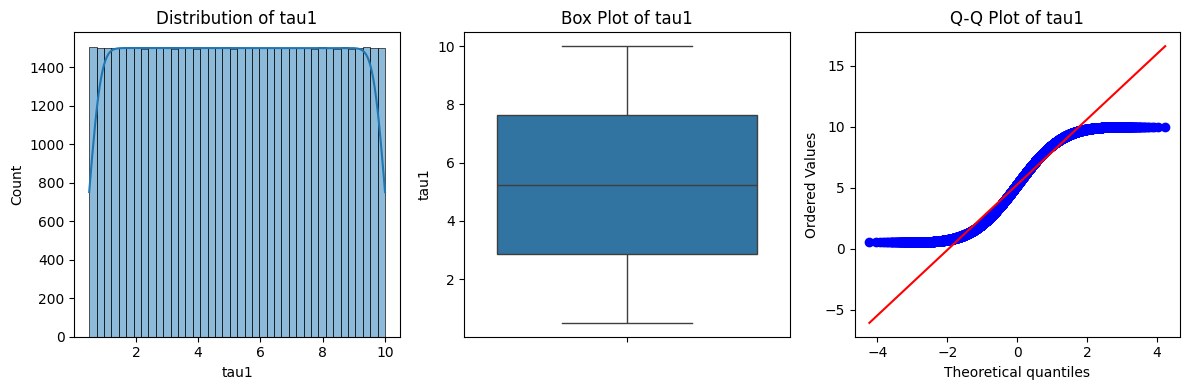


Skewness of tau1: -0.00
Kurtosis of tau1: -1.20


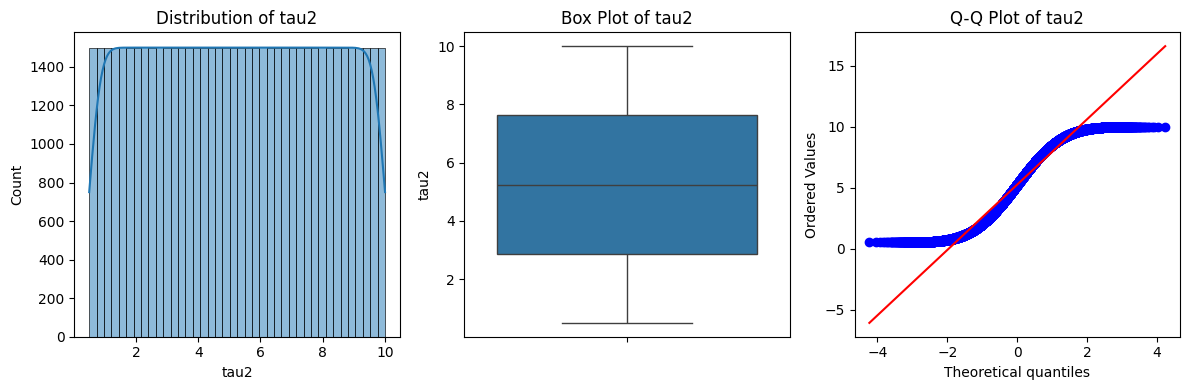


Skewness of tau2: -0.00
Kurtosis of tau2: -1.20


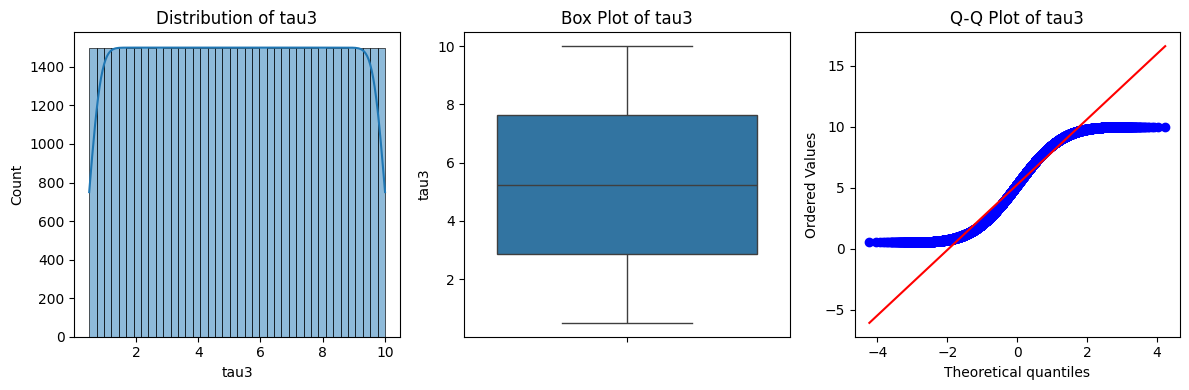


Skewness of tau3: -0.00
Kurtosis of tau3: -1.20


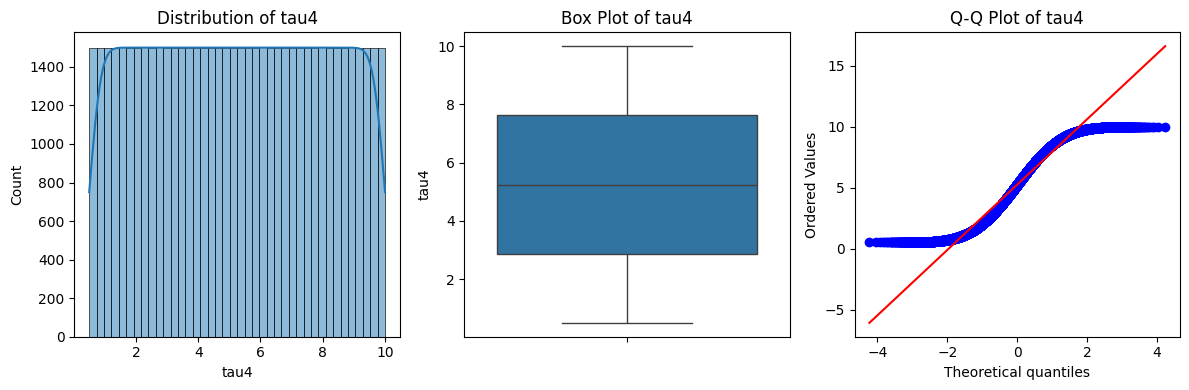


Skewness of tau4: -0.00
Kurtosis of tau4: -1.20


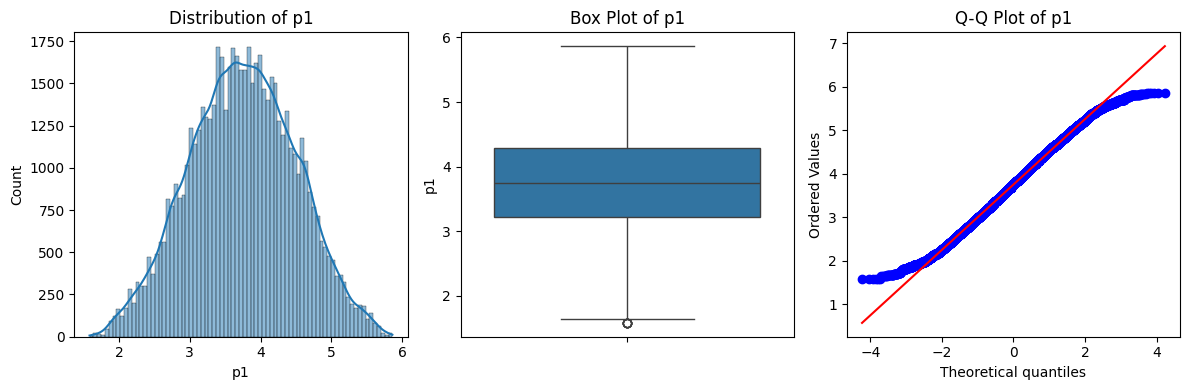


Skewness of p1: -0.01
Kurtosis of p1: -0.39


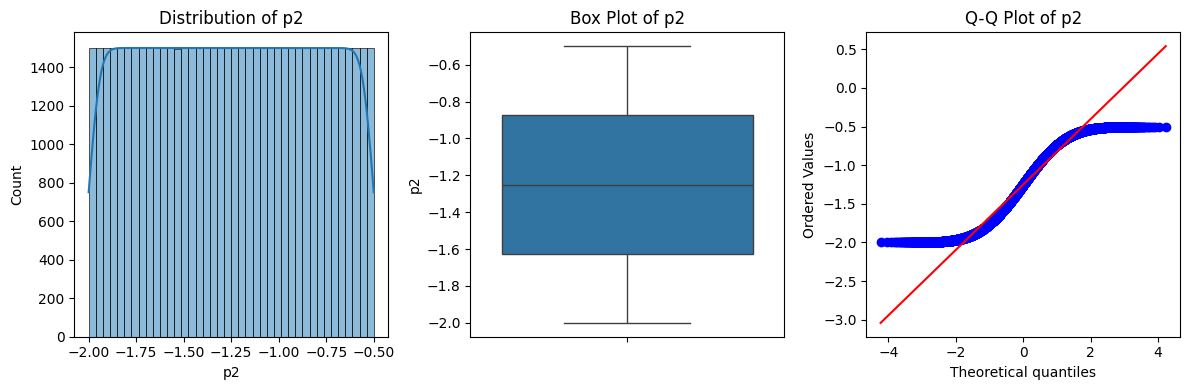


Skewness of p2: 0.00
Kurtosis of p2: -1.20


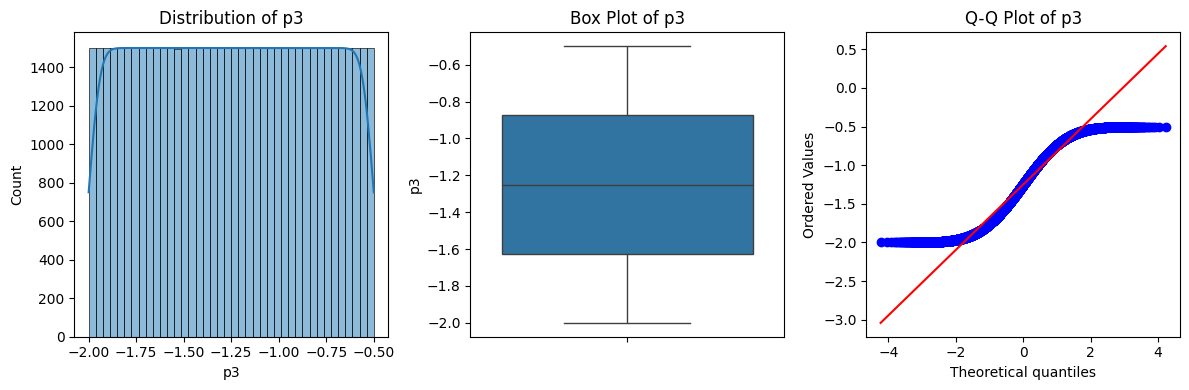


Skewness of p3: 0.00
Kurtosis of p3: -1.20


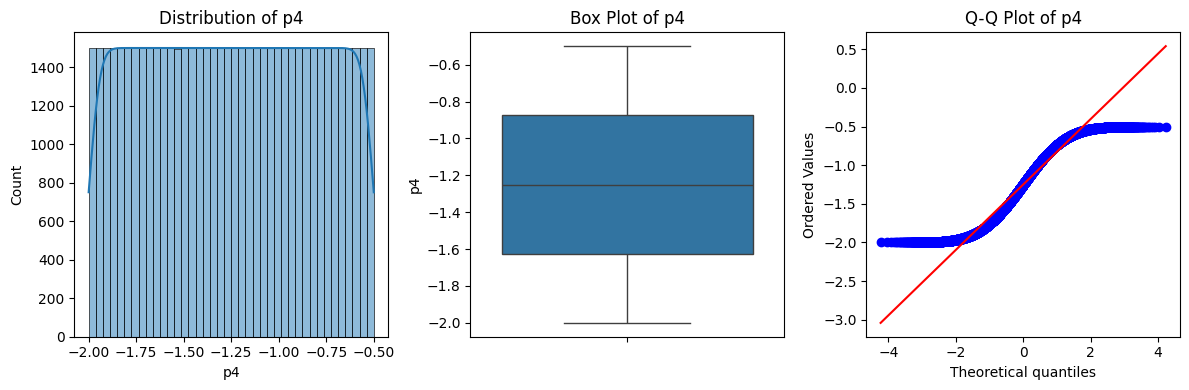


Skewness of p4: 0.00
Kurtosis of p4: -1.20


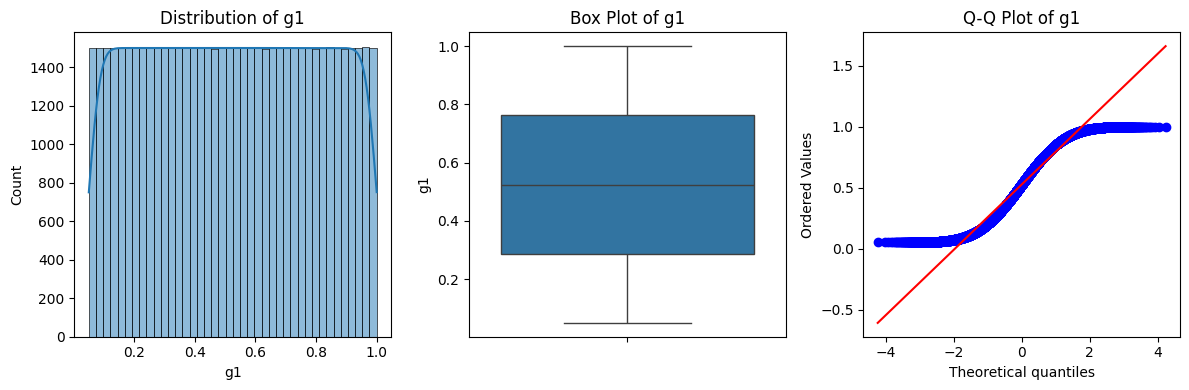


Skewness of g1: 0.00
Kurtosis of g1: -1.20


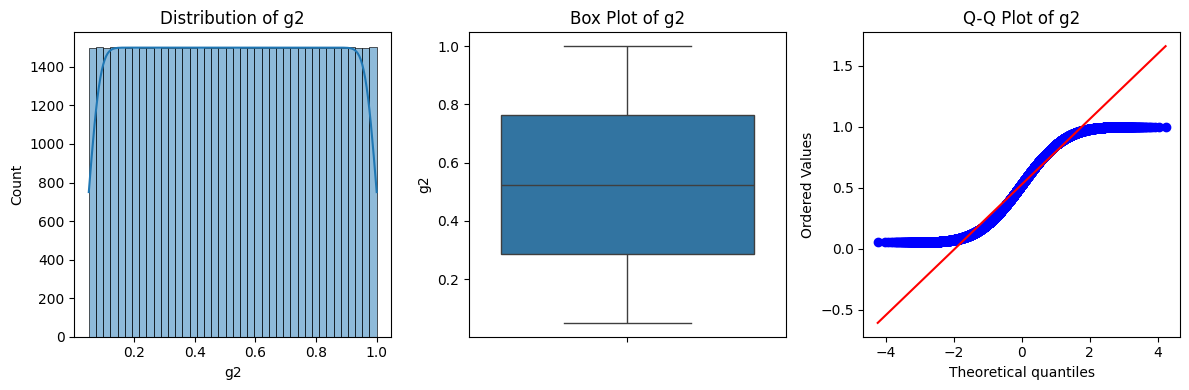


Skewness of g2: 0.00
Kurtosis of g2: -1.20


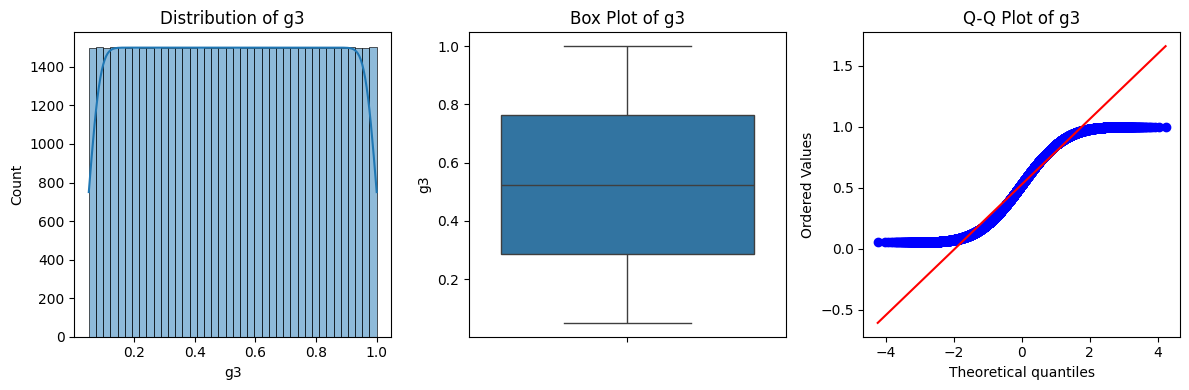


Skewness of g3: 0.00
Kurtosis of g3: -1.20


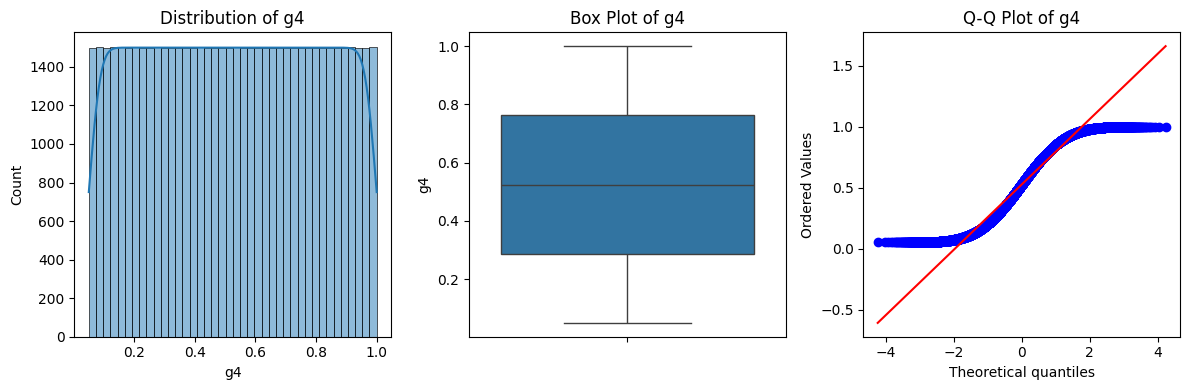


Skewness of g4: 0.00
Kurtosis of g4: -1.20


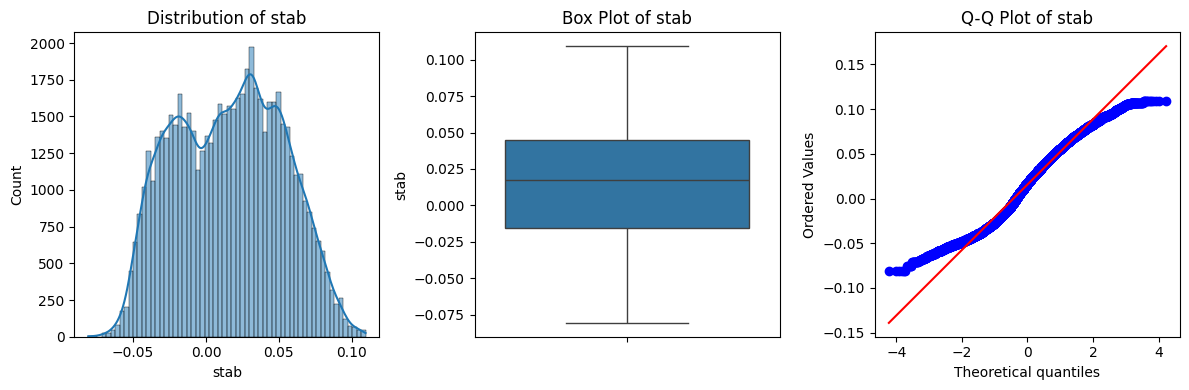


Skewness of stab: 0.02
Kurtosis of stab: -0.91

3. Correlation Analysis
--------------------------------------------------


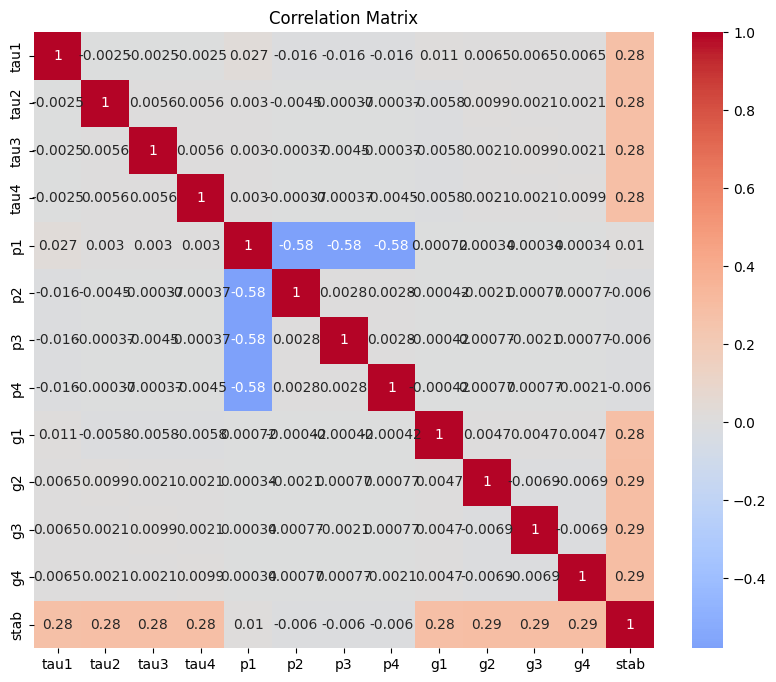


4. Categorical Analysis
--------------------------------------------------


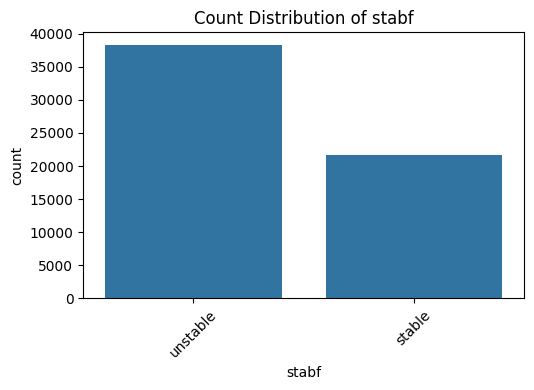


5. Outlier Analysis
--------------------------------------------------
Outlier Summary:
      count  percentage      min      max
tau1    0.0        0.00      NaN      NaN
tau2    0.0        0.00      NaN      NaN
tau3    0.0        0.00      NaN      NaN
tau4    0.0        0.00      NaN      NaN
p1      6.0        0.01  1.58259  1.58259
p2      0.0        0.00      NaN      NaN
p3      0.0        0.00      NaN      NaN
p4      0.0        0.00      NaN      NaN
g1      0.0        0.00      NaN      NaN
g2      0.0        0.00      NaN      NaN
g3      0.0        0.00      NaN      NaN
g4      0.0        0.00      NaN      NaN
stab    0.0        0.00      NaN      NaN


In [20]:
perform_eda(df)

<h2>Preprocessing the data</h2>

In [21]:
def replace_labels(x: str):
    if x == "unstable":
        return 0
    else:
        return 1


def preprocess_inputs(df, task="classification"):
    df = df.copy()
    if task == "classification":
        df = df.drop("stab", axis=1)
        y = df["stabf"].apply(replace_labels)
        x = df.drop("stabf", axis=1).copy()
    elif task == "regression":
        df = df.drop("stabf", axis=1)
        y = df["stab"]
        x = df.drop("stab", axis=1).copy()
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, train_size=0.7, shuffle=True, random_state=123
    )
    return x_train, x_test, y_train, y_test

<h2>Model Training and evaluatioin</h2>

In [22]:
x_train, x_test, y_train, y_test = preprocess_inputs(df, task='regression')

svm_reg = SVR()
svm_reg.fit(x_train, y_train)

y_pred = svm_reg.predict(x_test)
print(f"Regression score : {svm_reg.score(x_test, y_test)}")
print(f"RMSE : {root_mean_squared_error(y_test, y_pred)}")
print(f"MAE  : {mean_absolute_error(y_test, y_pred)}")

Regression score : -0.0015794571310954186
RMSE : 0.036963855199827866
MAE  : 0.031349403371748755


In [23]:
x_train, x_test, y_train, y_test = preprocess_inputs(df, task="classification")

svm_clf = SVC()
svm_clf.fit(x_train, y_train)

print("The Classification Score", svm_clf.score(x_test, y_test))
y_pred = svm_clf.predict(x_test)
print("Confusion matrix : ", confusion_matrix(y_true=y_test, y_pred=y_pred))
print("Precisioin : ", precision_score(y_test, y_pred))
print("Recall : ", recall_score(y_test, y_pred))

The Classification Score 0.9290555555555555
Confusion matrix :  [[11007   493]
 [  784  5716]]
Precisioin :  0.9205991302947335
Recall :  0.8793846153846154


In [24]:
x_train, x_test, y_train, y_test = preprocess_inputs(df, task='regression')

dtree_reg = DecisionTreeRegressor()
dtree_reg.fit(x_train, y_train)

y_pred = dtree_reg.predict(x_test)
print(f"Regression score : {dtree_reg.score(x_test, y_test)}")
print(f"RMSE : {root_mean_squared_error(y_test, y_pred)}")
print(f"MAE  : {mean_absolute_error(y_test, y_pred)}")

Regression score : 0.8262984197125864
RMSE : 0.01539346685399974
MAE  : 0.010852295476558428


In [25]:
x_train, x_test, y_train, y_test = preprocess_inputs(df, task="classification")

dtree_clf = DecisionTreeClassifier()
dtree_clf.fit(x_train, y_train)

print("The Classification Score", dtree_clf.score(x_test, y_test))
y_pred = dtree_clf.predict(x_test)
print("Confusion matrix : ", confusion_matrix(y_true=y_test, y_pred=y_pred))
print("Precisioin : ", precision_score(y_test, y_pred))
print("Recall : ", recall_score(y_test, y_pred))

The Classification Score 0.8882222222222222
Confusion matrix :  [[10517   983]
 [ 1029  5471]]
Precisioin :  0.8476913541989464
Recall :  0.8416923076923077


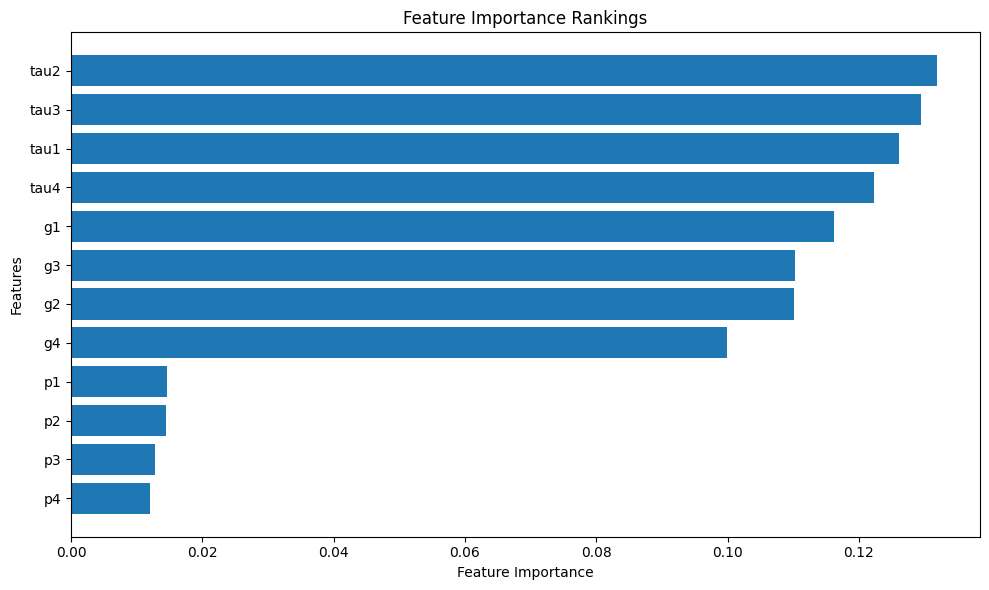

In [26]:
feature_importance = dtree_clf.feature_importances_
features = list(x_train.columns)

sorted_idx = feature_importance.argsort()
sorted_features = [features[i] for i in sorted_idx]
sorted_importance = feature_importance[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance)

plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Rankings')

plt.tight_layout()

plt.show()

In [27]:
new_df = df.drop(columns=['p1', 'p2', 'p3', 'p4'])
new_df.head()

,tau1,tau2,tau3,tau4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [28]:
x_train, x_test, y_train, y_test = preprocess_inputs(new_df, task='regression')

new_svm_reg = SVR()
new_svm_reg.fit(x_train, y_train)

y_pred = new_svm_reg.predict(x_test)
print(f"Regression score : {new_svm_reg.score(x_test, y_test)}")
print(f"RMSE : {root_mean_squared_error(y_test, y_pred)}")
print(f"MAE  : {mean_absolute_error(y_test, y_pred)}")

Regression score : -0.0015794571310954186
RMSE : 0.036963855199827866
MAE  : 0.031349403371748755


In [29]:
x_train, x_test, y_train, y_test = preprocess_inputs(new_df, task="classification")

new_svm_clf = SVC()
new_svm_clf.fit(x_train, y_train)

print("The Classification Score", new_svm_clf.score(x_test, y_test))
y_pred = new_svm_clf.predict(x_test)
print("Confusion matrix : ", confusion_matrix(y_true=y_test, y_pred=y_pred))
print("Precisioin : ", precision_score(y_test, y_pred))
print("Recall : ", recall_score(y_test, y_pred))

The Classification Score 0.9421111111111111
Confusion matrix :  [[11069   431]
 [  611  5889]]
Precisioin :  0.9318037974683544
Recall :  0.906


In [30]:
x_train, x_test, y_train, y_test = preprocess_inputs(new_df, task='regression')

new_dtree_reg = DecisionTreeRegressor()
new_dtree_reg.fit(x_train, y_train)

y_pred = new_dtree_reg.predict(x_test)
print(f"Regression score : {new_dtree_reg.score(x_test, y_test)}")
print(f"RMSE : {root_mean_squared_error(y_test, y_pred)}")
print(f"MAE  : {mean_absolute_error(y_test, y_pred)}")

Regression score : 0.8359113085398306
RMSE : 0.01496145676675321
MAE  : 0.010481440328778508


In [31]:
x_train, x_test, y_train, y_test = preprocess_inputs(new_df, task="classification")

new_dtree_clf = DecisionTreeClassifier()
new_dtree_clf.fit(x_train, y_train)

print("The Classification Score", new_dtree_clf.score(x_test, y_test))
y_pred = new_dtree_clf.predict(x_test)
print("Confusion matrix : ", confusion_matrix(y_true=y_test, y_pred=y_pred))
print("Precisioin : ", precision_score(y_test, y_pred))
print("Recall : ", recall_score(y_test, y_pred))

The Classification Score 0.8976111111111111
Confusion matrix :  [[10610   890]
 [  953  5547]]
Precisioin :  0.8617368339288488
Recall :  0.8533846153846154
